In [1]:
# === Notebook environment setup ===

import sys
import os
from pathlib import Path

# Projektwurzel automatisch finden
def find_project_root(start: Path, marker="bootstrap.py"):
    start = start.resolve()
    p = start
    while True:
        if (p / marker).exists():
            return p
        if p.parent == p:
            raise RuntimeError("Projektwurzel nicht gefunden.")
        p = p.parent

project_root = find_project_root(Path.cwd())
os.chdir(project_root)
sys.path.insert(0, str(project_root))

print("📁 Projektwurzel:", project_root)

📁 Projektwurzel: /Users/jakobkoppermann/Coding/inat_habitat_modeling


In [1]:
!pip3 install pandas numpy rasterio scipy plotly shap

In [4]:
!python "analyse/trend_map.py" \
    --folder "/Volumes/Data/iNaturalist/outputs/macrolepiota_procera" \
    --start 2017 \
    --end 2024 \
    --threshold 0.8 \
    --mode slope \
    --out "trend_map_2017_2024.tif"

📥 Lade alle Jahreskarten…
➡ Lade /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2017_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
➡ Lade /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2018_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
➡ Lade /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2019_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
➡ Lade /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2020_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
➡ Lade /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2021_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
➡ Lade /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2022_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
➡ Lade /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2023_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
➡ Lade /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2024_MONTHL

📊 Anzahl gültiger Trend-Pixel in Stichprobe: 200,000


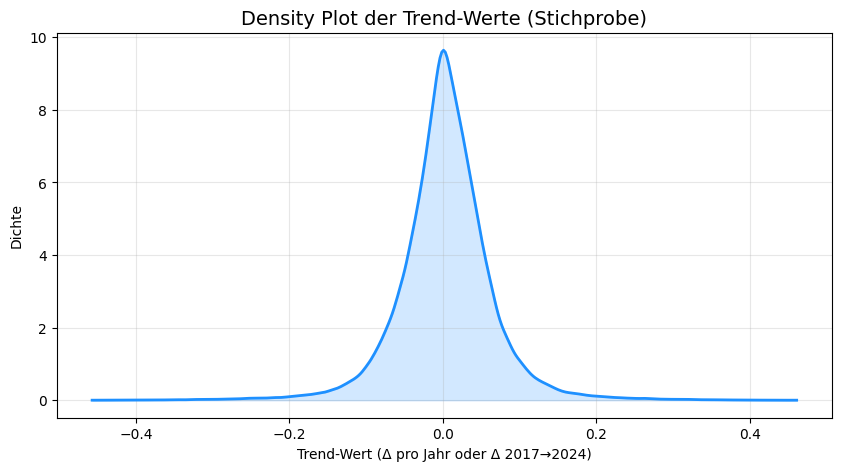

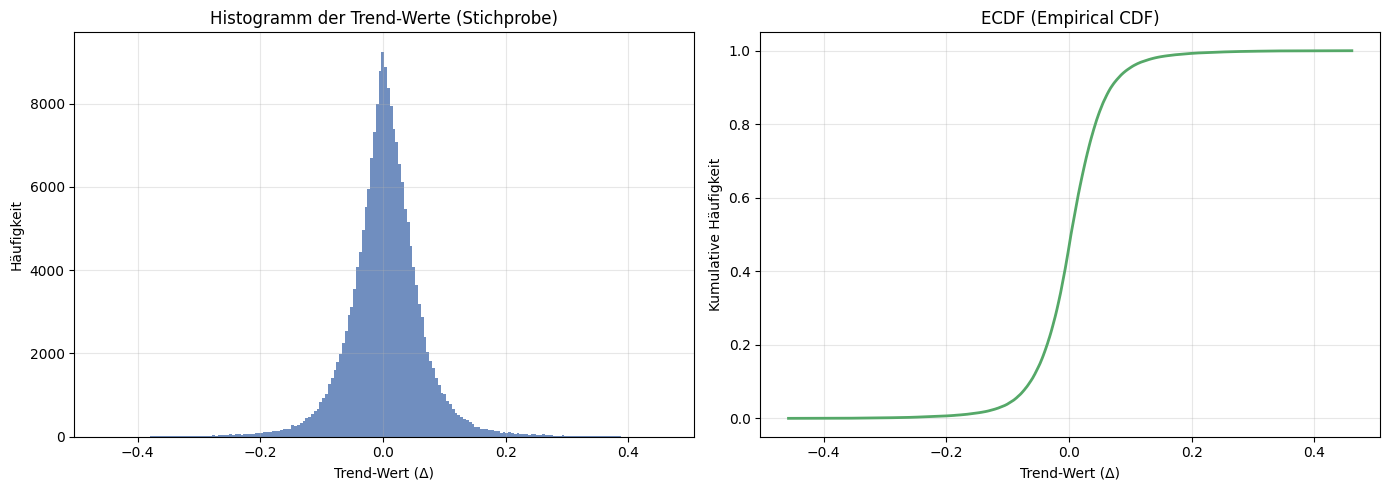

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------
# Einstellungen
# -------------------------------------------------------
TREND_TIF = "/Volumes/Data/iNaturalist/outputs/trend_map_2017_2024.tif"
MAX_SAMPLES = 200_000       # Stichprobengröße
REAL_THRESHOLD = 0.8        # nur echte Pixel auf Basis der Mask-Bandlogik
MASK_BAND = 2               # falls deine Trend-Karte denselben Mask-Aufbau nutzt

# -------------------------------------------------------
# Raster laden (Werte + Mask optional)
# -------------------------------------------------------
with rasterio.open(TREND_TIF) as src:
    trend = src.read(1).astype("float32")

    # Falls Maskenband existiert → mitladen
    mask = src.read(MASK_BAND).astype("float32") if src.count >= 2 else None

# -------------------------------------------------------
# Maskierung anwenden
# -------------------------------------------------------
valid = np.isfinite(trend)
if mask is not None:
    valid &= (mask >= REAL_THRESHOLD)

trend_valid = trend[valid]

# Stichprobe ziehen
if len(trend_valid) > MAX_SAMPLES:
    idx = np.random.choice(len(trend_valid), MAX_SAMPLES, replace=False)
    trend_sample = trend_valid[idx]
else:
    trend_sample = trend_valid

print(f"📊 Anzahl gültiger Trend-Pixel in Stichprobe: {len(trend_sample):,}")

# -------------------------------------------------------
# KDE-Dichte berechnen
# -------------------------------------------------------
kde = gaussian_kde(trend_sample)
xs = np.linspace(trend_sample.min(), trend_sample.max(), 400)
ys = kde(xs)

# -------------------------------------------------------
# Plot
# -------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(xs, ys, color="dodgerblue", linewidth=2)
plt.fill_between(xs, 0, ys, color="dodgerblue", alpha=0.2)

plt.title("Density Plot der Trend-Werte (Stichprobe)", fontsize=14)
plt.xlabel("Trend-Wert (Δ pro Jahr oder Δ 2017→2024)")
plt.ylabel("Dichte")
plt.grid(alpha=0.3)

plt.show()


import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# -----------------------------------------
# Trendwerte laden (Beispiel)
# trend_sample = np.load("trend_sample.npy")
# -----------------------------------------

# Beispiel: du hast schon "trend_sample"
trend = trend_sample  # array mit tausenden Trendwerten

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --------------------
# 1) Histogramm
# --------------------
axes[0].hist(trend, bins=200, color="#4C72B0", alpha=0.8)
axes[0].set_title("Histogramm der Trend-Werte (Stichprobe)")
axes[0].set_xlabel("Trend-Wert (Δ)")
axes[0].set_ylabel("Häufigkeit")
axes[0].grid(alpha=0.3)

# --------------------
# 2) ECDF
# --------------------
ecdf = ECDF(trend)
axes[1].plot(ecdf.x, ecdf.y, linewidth=2, color="#55A868")
axes[1].set_title("ECDF (Empirical CDF)")
axes[1].set_xlabel("Trend-Wert (Δ)")
axes[1].set_ylabel("Kumulative Häufigkeit")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
!python analyse/spatial_trend_stats.py \
  --trend "/Volumes/Data/iNaturalist/outputs/trend_map_2017_2024.tif" \
  --qa "/Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2024_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif" \
  --qa_min 0.8 \
  --tile 512 \
  --out_prefix "/Volumes/Data/iNaturalist/outputs/trendstats_2017_2024"

/Users/jakobkoppermann/Coding/inat_habitat_modeling/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
📦 Prozessiere 506 Tiles (22×23)…
📊 Berechne globale Trend-Quantile…
[Tile 1/506] y=0:512 x=0:512
Traceback (most recent call last):
  File "/Users/jakobkoppermann/Coding/inat_habitat_modeling/analyse/spatial_trend_stats.py", line 191, in <module>
    main()
  File "/Users/jakobkoppermann/Coding/inat_habitat_modeling/analyse/spatial_trend_stats.py", line 181, in main
    process_tiles(
  File "/Users/jakobkoppermann/Coding/inat_habitat_modeling/analyse/spatial_trend_stats.py", line 116, in process_tiles
    lisa = Moran(vec, Wt, permutations=0)
  File "/Users/jakobkoppermann/Coding/inat_habitat_modeling/venv/lib/python3.9/site-packages/esda/moran.py", line 166, in __init__
    self.I = self._

In [4]:
!python analyse/spatial_trend_stats.py \
      --trend "/Volumes/Data/iNaturalist/outputs/trend_map_2017_2024.tif" \
      --qa_folder "/Volumes/Data/iNaturalist/outputs/macrolepiota_procera" \
      --qa_min 0.5 \
      --tile 512 \
      --out_prefix "/Volumes/Data/iNaturalist/outputs/trendstats_2017_2024"

/Users/jakobkoppermann/Coding/inat_habitat_modeling/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
📥 Lade Trendkarte…
   Größe: 11094 × 11351
📥 Lade QA aller Jahre für Trend-QA…
  → 2017: /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2017_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
  → 2018: /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2018_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
  → 2019: /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2019_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
  → 2020: /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2020_MONTHLY_Macrolepiota_procera_vs_Parus_major.tif
  → 2021: /Volumes/Data/iNaturalist/outputs/macrolepiota_procera/suitability_2021_MONTHLY_Macrolepiot